In [1]:
import numpy as np
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import matplotlib.pyplot as plt
# from numba import prange, njit
import time
from mpl_toolkits.mplot3d import Axes3D
from fireworks.ic import ic_tf as fic_tf 
from fireworks.ic import ic as fic
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.timesteps as ftim
from tqdm.notebook import tqdm
from fireworks.particles import Particles_tf,Particles
import multiprocessing
from multiprocessing import Pool, Manager
import psutil
import pandas as pd
import cProfile
import json

tf.config.optimizer.set_jit(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."
 

2024-06-04 12:22:22.771741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:22:22.771783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:22:22.772977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 12:22:22.779342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 12:22:23.430790: W tensorflow/compiler/tf2

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-06-04 12:22:24.843240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 12:22:24.884604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 12:22:24.885025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## GPU and Direct

In [2]:
def initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass,seed):
    
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass,seed =seed,
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert np.min(particles.pos) >= min_pos and np.max(particles.pos) <= max_pos
    assert np.min(particles.vel) >= min_vel and np.max(particles.vel) <= max_vel
    assert np.min(particles.mass) >= min_mass and np.max(particles.mass) <= max_mass
    return particles

def initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass,seed):
    
    particles = fic_tf.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass,seed = seed
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert tf.reduce_min(particles.pos) >= min_pos and tf.reduce_max(particles.pos) <= max_pos
    assert tf.reduce_min(particles.vel) >= min_vel and tf.reduce_max(particles.vel) <= max_vel
    assert tf.reduce_min(particles.mass) >= min_mass and tf.reduce_max(particles.mass) <= max_mass
    return particles



In [3]:
def measure_compile_time_and_memory(particles, facc_list):
    compile_times = []
    cpu_memory_usages = []
    gpu_memory_usages = []
    
    for facc in facc_list:
        # Measure CPU memory usage
        process = psutil.Process()
        start_cpu_memory = process.memory_info().rss
        t1 = time.perf_counter()
        
        # Call the acceleration function
        acceleration = facc(particles, softening=1e-10)
        # print(f"{facc.__name__}\n:{acceleration[0]}")
        t2 = time.perf_counter()
        end_cpu_memory = process.memory_info().rss
        
        # Calculate time and CPU memory usage
        dt = t2 - t1
        compile_times.append(dt)
        d_cpu_mem = end_cpu_memory - start_cpu_memory
        cpu_memory_usages.append(d_cpu_mem / 1e6)  # Convert to MB
        
        # Measure GPU memory usage
        gpu_memory_info = tf.config.experimental.get_memory_info('GPU:0')
        gpu_memory_usages.append(gpu_memory_info['current'] / 1e6)  # Convert to MB
        
        # Clear TensorFlow session to reset GPU memory to ensure each function starts with the same initial GPU memory state.
        tf.keras.backend.clear_session()
        
        print(f"Time taken for acceleration using {facc.__name__}: {dt} seconds")
        print(f"CPU Memory usage: {d_cpu_mem / 1e6} MB")
        # print(f"GPU Memory usage: {gpu_memory_info['current'] / 1e6} MB")
    
    return compile_times, cpu_memory_usages, gpu_memory_usages


def test_time_and_memory_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, seed, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N"):
        particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass,seed)
        compile_times, cpu_memory_usages, gpu_memory_usages = measure_compile_time_and_memory(particles, facc_list)
        results[n_particles] = {
            'particles': particles,
            'compile_times': compile_times, 
            'cpu_memory_usages': cpu_memory_usages,
            'gpu_memory_usages': gpu_memory_usages
        }
    return results

def test_time_and_memory_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, seed, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N_tf"):
        particles_tf = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, seed)
        compile_times, cpu_memory_usages, gpu_memory_usages = measure_compile_time_and_memory(particles_tf, facc_list)
        results[n_particles] = {
            'particles': particles_tf,
            'compile_times': compile_times,
            'cpu_memory_usages': cpu_memory_usages,
            'gpu_memory_usages': gpu_memory_usages
        }
    return results


In [28]:
# Defining initial conditions for the test
# N = np.logspace(1, 4, 15).astype(int)
N = np.linspace(10,9000,10).astype(int)

min_pos = 10.
max_pos = 100.
min_vel = 10.
max_vel = 100.
min_mass = 10.
max_mass = 100.
seed = 1


facc_list = [
    # fdyn.acceleration_direct,
    fdyn.acceleration_direct_vectorized,
    # fdyn.acceleration_pyfalcon
            ]
# facc_list_tf = [
#     fdyn.acceleration_tf,
#     fdyn.acceleration_direct_tf,
# ]

# output_results_tf = test_time_and_memory_ic_random_uniform_tf(
#     N,
#     min_pos,
#     max_pos,
#     min_vel,
#     max_vel,
#     min_mass,
#     max_mass,
#     seed,
#     facc_list_tf
# )
# output_results = test_time_and_memory_ic_random_uniform(
#     N,
#     min_pos,
#     max_pos,
#     min_vel,
#     max_vel,
#     min_mass,
#     max_mass,
#     seed,
#     facc_list
# )


In [29]:
# cProfile.run("test_time_and_memory_ic_random_uniform_tf(np.array([200]),min_pos,max_pos,min_vel,max_vel,min_mass,max_mass,seed,facc_list_tf)",sort =1)
cProfile.run("test_time_and_memory_ic_random_uniform(np.array([500]),min_pos,max_pos,min_vel,max_vel,min_mass,max_mass,seed,facc_list)"
             ,sort =1)             
             

 N:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 500 particles 

Time taken for acceleration using acceleration_direct_vectorized: 0.027267669000138994 seconds
CPU Memory usage: -0.827392 MB
         18874 function calls (16947 primitive calls) in 0.061 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.023    0.023    0.026    0.026 dynamics.py:181(acceleration_direct_vectorized)
       40    0.003    0.000    0.003    0.000 {method 'acquire' of '_thread.lock' objects}
       51    0.002    0.000    0.003    0.000 traitlets.py:1882(traits)
 1386/849    0.001    0.000    0.016    0.000 traitlets.py:651(get)
        3    0.001    0.000    0.001    0.000 ufunclike.py:71(isposinf)
 1693/934    0.001    0.000    0.016    0.000 traitlets.py:689(__get__)
       76    0.001    0.000    0.001    0.000 encoder.py:205(iterencode)
        3    0.001    0.000    0.003    0.001 type_check.py:403(nan_to_num)
      151    0.001    0.000    0.001    0.000 traitlets.py:

# CPU Parallelization using Multiprocessing

In [18]:
# Define the new parallel acceleration function
def parallel_vectorized_acc(s_index, e_index, shared_data):
    pos = shared_data['pos']
    N_particles = shared_data['N_particles']
    mass = shared_data['mass']

    dx = pos[s_index:e_index, 0, np.newaxis] - pos[:, 0]
    dy = pos[s_index:e_index, 1, np.newaxis] - pos[:, 1]
    dz = pos[s_index:e_index, 2, np.newaxis] - pos[:, 2]

    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r == 0] = 1

    dist = np.concatenate((dx, dy, dz)).reshape((3, e_index - s_index, N_particles))

    acc = - (dist / r**3 @ mass).T
    jerk = None
    pot = None

    return acc, jerk, pot

def parallel_acceleration_direct(s_index, e_index, shared_data):
    pos = shared_data['pos']
    N_particles = shared_data['N_particles']
    mass = shared_data['mass']

    dim_batch = e_index - s_index
    acc = np.zeros((dim_batch, 3))

    for i in range(dim_batch):
        for j in range(N_particles):
            if j != i:
                dx = pos[s_index + i, 0] - pos[j, 0]
                dy = pos[s_index + i, 1] - pos[j, 1]
                dz = pos[s_index + i, 2] - pos[j, 2]

                r = np.sqrt(dx**2 + dy**2 + dz**2)
                if r == 0:
                    r = 1

                acc_ij = np.zeros(3)
                acc_ij[0] = dx / (r ** 3)
                acc_ij[1] = dy / (r ** 3)
                acc_ij[2] = dz / (r ** 3)

                for k in range(3):
                    acc[i, k] -= acc_ij[k] * mass[j]

    return acc, None, None

def parallel_vectorized_integrator(s_index, e_index, shared_data, tstep):
    vel = shared_data['vel']
    pos = shared_data['pos']

    acc, _, _ = parallel_vectorized_acc(s_index, e_index, shared_data)
    # print(f"parallel vect:\n{acc}")

    vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep
    pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep

    shared_data['vel'][s_index:e_index] = vel[s_index:e_index]
    shared_data['pos'][s_index:e_index] = pos[s_index:e_index]

    return pos[s_index:e_index], vel[s_index:e_index]

def parallel_direct_integrator(s_index, e_index, shared_data, tstep):
    vel = shared_data['vel']
    pos = shared_data['pos']

    acc, _, _ = parallel_acceleration_direct(s_index, e_index, shared_data)
    # print(f"parallel direct:\n{acc}")
    vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep
    pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep

    shared_data['vel'][s_index:e_index] = vel[s_index:e_index]
    shared_data['pos'][s_index:e_index] = pos[s_index:e_index]

    return pos[s_index:e_index], vel[s_index:e_index]

def parallel_vectorized_evo(N_particles, total_evo_time,N_CORES):
    global pos, vel, mass

    # N_CORES = multiprocessing.cpu_count()
    N_PROCESSES = min(N_CORES, N_particles)

    with Manager() as manager:
        shared_data = manager.dict()
        shared_data['pos'] = pos
        shared_data['vel'] = vel
        shared_data['mass'] = mass
        shared_data['N_particles'] = N_particles

        pool = Pool(N_PROCESSES)
        tstep = 0.01

        positions = []
        process = psutil.Process()
        # memory_usages = []

        for _ in range(int(total_evo_time / tstep)):
            # start_memory = process.memory_info().rss

            if N_particles < N_CORES:
                future_results = pool.starmap_async(parallel_vectorized_integrator, 
                                                    [(i, (i + 1), shared_data, tstep) for i in range(N_particles)])
            else:
                future_results = pool.starmap_async(parallel_vectorized_integrator, 
                                                    [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES, shared_data, tstep) for i in range(N_PROCESSES)])

            results = future_results.get()
            pos = np.concatenate([results[i][0] for i in range(len(results))])
            vel = np.concatenate([results[i][1] for i in range(len(results))])
            shared_data['pos'] = pos
            shared_data['vel'] = vel

            positions.append(pos)

            # end_memory = process.memory_info().rss
            # memory_usages.append(end_memory - start_memory)

        pool.close()
        pool.join()

    return positions#, memory_usages

def parallel_direct_evo(N_particles, total_evo_time,N_CORES):
    global pos, vel, mass

    # N_CORES = multiprocessing.cpu_count()
    N_PROCESSES = min(N_CORES, N_particles)

    with Manager() as manager:
        shared_data = manager.dict()
        shared_data['pos'] = pos
        shared_data['vel'] = vel
        shared_data['mass'] = mass
        shared_data['N_particles'] = N_particles

        pool = Pool(N_PROCESSES)
        tstep = 0.01

        positions = []
        process = psutil.Process()
        # memory_usages = []

        for _ in range(int(total_evo_time / tstep)):
            # start_memory = process.memory_info().rss

            if N_particles < N_CORES:
                future_results = pool.starmap_async(parallel_direct_integrator, 
                                                    [(i, (i + 1), shared_data, tstep) for i in range(N_particles)])
            else:
                future_results = pool.starmap_async(parallel_direct_integrator, 
                                                    [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES, shared_data, tstep) for i in range(N_PROCESSES)])

            results = future_results.get()
            pos = np.concatenate([results[i][0] for i in range(len(results))])
            vel = np.concatenate([results[i][1] for i in range(len(results))])
            shared_data['pos'] = pos
            shared_data['vel'] = vel

            positions.append(pos)

            # end_memory = process.memory_info().rss
            # memory_usages.append(end_memory - start_memory)

        pool.close()
        pool.join()

    return positions#, memory_usages


In [30]:
#### CPU-Parallelization Main #######
times_parallel_vec = []
memory_parallel_vec = []
times_parallel_direct = []
memory_parallel_direct = []

N = np.array([15000])

for n_particles in N:
    start = time.time()
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    pos = particles.pos
    vel = particles.vel
    mass = particles.mass
    N_particles = len(particles)
    tstep = 0.01

    result_parallel_vec= parallel_vectorized_evo(n_particles, total_evo_time=tstep,N_CORES = 16)
    times_parallel_vec.append(time.time() - start)
    result_parallel_vec_1= parallel_vectorized_evo(n_particles, total_evo_time=tstep,N_CORES = 8)
    times_parallel_vec.append(time.time() - start)
    # memory_parallel_vec.append(max(memory_usages_vec) / 1e6)  # Convert bytes to MB
    
    # start = time.time()
    # result_parallel_direct= parallel_direct_evo(n_particles, total_evo_time=tstep,N_CORES = 16)
    # times_parallel_direct.append(time.time() - start)
    # memory_parallel_direct.append(max(memory_usages_direct) / 1e6)  # Convert bytes to MB

In [35]:
 # cProfile.run("parallel_vectorized_evo(200, total_evo_time=0.01)",sort = 1)
# cProfile.run("parallel_direct_evo(9000, total_evo_time=0.01)",sort = 1)
cProfile.run("parallel_vectorized_evo(15000, total_evo_time=0.01,N_CORES = 16)",sort = 1)
cProfile.run("parallel_vectorized_evo(15000, total_evo_time=0.01,N_CORES = 4)",sort = 1)

         5079 function calls (5078 primitive calls) in 0.613 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       17    0.274    0.016    0.275    0.016 {built-in method posix.fork}
      250    0.251    0.001    0.251    0.001 {method 'acquire' of '_thread.lock' objects}
        1    0.042    0.042    0.042    0.042 {method 'poll' of 'select.poll' objects}
       50    0.015    0.000    0.015    0.000 {built-in method posix.read}
       68    0.003    0.000    0.003    0.000 socket.py:621(send)
       17    0.002    0.000    0.279    0.016 popen_fork.py:62(_launch)
       17    0.002    0.000    0.003    0.000 process.py:61(_cleanup)
       20    0.001    0.000    0.001    0.000 util.py:186(__init__)
       34    0.001    0.000    0.030    0.001 iostream.py:547(flush)
       17    0.001    0.000    0.002    0.000 process.py:80(__init__)
       26    0.001    0.000    0.001    0.000 {method 'copy' of 'dict' objects}
     

ValueError: cannot reshape array of size 0 into shape (3,937,15000)

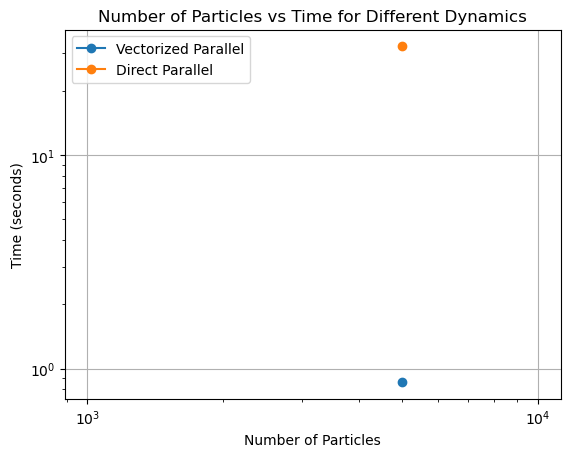

In [19]:
# Plotting non-TensorFlow time results
# for facc, label in zip(facc_list,
#                        ['acceleration_direct',
#                         'acceleration_direct_vectorized',
#                         'acceleration_pyfalcon'
#                         ]):
#     times = [output_results[n]['compile_times'][facc_list.index(facc)] for n in N]
#     plt.plot(N, times, marker='o', label=f'{label} (Time)')

# # Plotting TensorFlow time results
# for facc, label in zip(facc_list_tf, ['acceleration_tf',
#                                      'acceleration_direct_tf'
#                                      ]):
#     times = [output_results_tf[n]['compile_times'][facc_list_tf.index(facc)] for n in N]
#     plt.plot(N, times, marker='o', label=f'{label}')

plt.plot(N, times_parallel_vec, label="Vectorized Parallel", marker='o')
plt.plot(N, times_parallel_direct, label="Direct Parallel", marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles')
plt.ylabel('Time (seconds)')
plt.title('Number of Particles vs Time for Different Dynamics')
plt.legend()
plt.grid(True)
plt.savefig("9k_particle_vs_time.jpg")
plt.show()


In [21]:
def save_particle_vs_time_data(filename,
                               N,
                               output_results,
                               output_results_tf,
                               times_parallel_vec,
                               times_parallel_direct,
                               facc_list, facc_list_tf
                              ):
    with open(filename, 'w') as file:
        # Write the header
        file.write('Number of Particles, acceleration_direct, acceleration_direct_vectorized, acceleration_pyfalcon, acceleration_tf, acceleration_direct_tf, Vectorized Parallel, Direct Parallel\n')
        
        for i, n in enumerate(N):
            # for non-TensorFlow accelerations
            times = [output_results[n]['compile_times'][facc_list.index(facc)] for facc in facc_list]
            # for TensorFlow accelerations
            times_tf = [output_results_tf[n]['compile_times'][facc_list_tf.index(facc)] for facc in facc_list_tf]
            # for parallel implementations
            time_vec_parallel = times_parallel_vec[i]
            time_direct_parallel = times_parallel_direct[i]
            # Write all times for the current number of particles
            file.write(f'{n}, {times[0]}, {times[1]}, {times[2]}, {times_tf[0]}, {times_tf[1]}, {time_vec_parallel}, {time_direct_parallel}\n')


filename = 'particle_vs_time_data.txt'
save_particle_vs_time_data(filename, N, output_results, output_results_tf, times_parallel_vec, times_parallel_direct, facc_list, facc_list_tf)

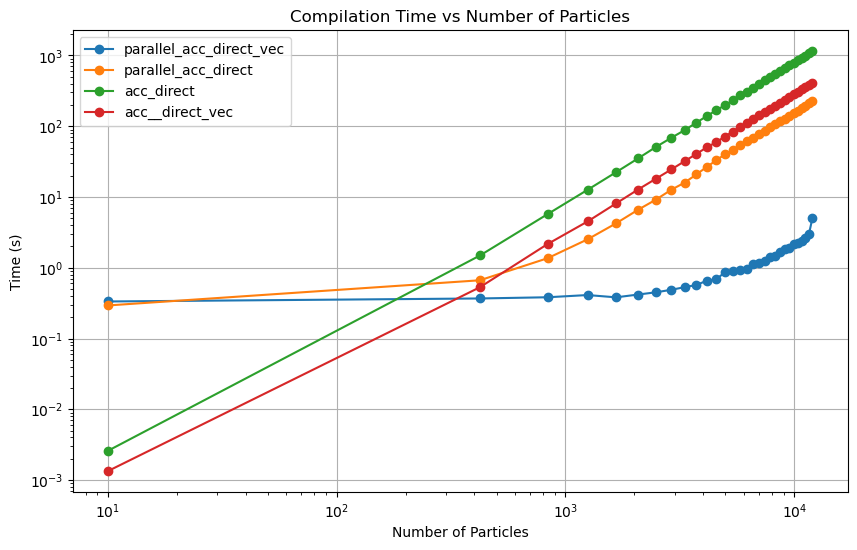

In [29]:
data = pd.read_csv("./compilation_times.txt")

particles = data['Particles']
t_TF_cpu = data['t_TF_cpu']
t_parallel_vec = data['t_parallel_vec']
t_parallel_direct = data['t_parallel_direct']
t_direct = data['t_direct']
t_vect = data['t_vect']
t_pyfalcon = data['t_pyfalcon']
t_TF_gpu = data['t_TF_gpu']

# Plotting the data
plt.figure(figsize=(10, 6))
# plt.plot(particles, t_TF_cpu, label='t_TF_cpu', marker='o')
plt.plot(particles, t_parallel_vec, label='parallel_acc_direct_vec', marker='o')
plt.plot(particles, t_parallel_direct, label='parallel_acc_direct', marker='o')
plt.plot(particles, t_direct, label='acc_direct', marker='o')
plt.plot(particles, t_vect, label='acc__direct_vec', marker='o')
# plt.plot(particles, t_pyfalcon, label='t_pyfalcon', marker='o')
# plt.plot(particles, t_TF_gpu, label='t_TF_gpu', marker='o')

# Adding labels and legend
plt.xlabel('Number of Particles')
plt.ylabel('Time (s)')
plt.title('Compilation Time vs Number of Particles')
plt.loglog()
plt.legend()
plt.grid(True)
plt.savefig("Compilation Time vs Number of Particles.jpg")
plt.show()

In [15]:
data

,Particles,t_TF_cpu,t_parallel_vec,t_parallel_direct,t_parallel_direct.1,t_vect,t_pyfalcon,t_TF_gpu
0,10,0.007460,0.334263,0.293708,0.002591,0.001339,0.000181,3.847522
1,423,0.014510,0.368676,0.666463,1.492178,0.531877,0.000528,0.008779
2,836,0.033379,0.383396,1.366779,5.738071,2.168718,0.000940,0.010061
3,1250,0.047680,0.412078,2.526198,12.661533,4.519321,0.001382,0.008430
4,1663,0.072086,0.382432,4.242503,22.383665,8.106586,0.001923,0.008008
5,2077,0.103176,0.418834,6.610182,35.144917,12.775400,0.002379,0.007789
6,2490,0.126038,0.451022,9.225789,51.163984,18.203453,0.003093,0.008381
7,2904,0.197623,0.489216,12.694445,68.806148,24.574725,0.003505,0.008983
8,3317,0.253033,0.532568,15.973254,88.130338,32.091098,0.004529,0.009387
9,3731,0.316457,0.570896,20.824545,112.091647,40.527511,0.005045,0.007294


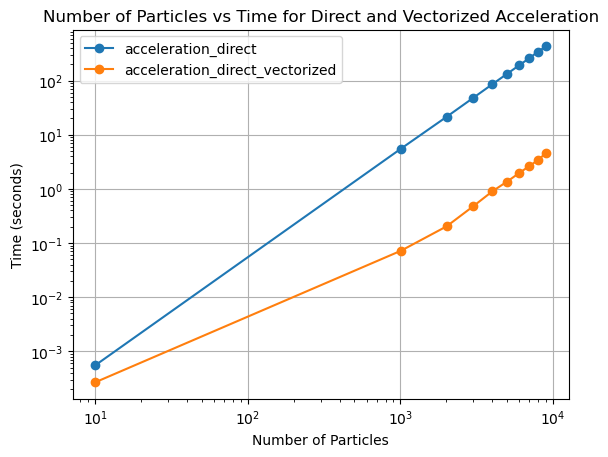

In [25]:
times_acceleration_direct = [output_results[n]['compile_times'][facc_list.index(fdyn.acceleration_direct)] for n in N]
times_acceleration_direct_vectorized = [output_results[n]['compile_times'][facc_list.index(fdyn.acceleration_direct_vectorized)] for n in N]

plt.plot(N, times_acceleration_direct, marker='o', label='acceleration_direct')
plt.plot(N, times_acceleration_direct_vectorized, marker='o', label='acceleration_direct_vectorized')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles')
plt.ylabel('Time (seconds)')
plt.title('Number of Particles vs Time for Direct and Vectorized Acceleration')
plt.legend()
plt.grid(True)
plt.savefig("particle_vs_time_direct_vs_vectorized.jpg")
plt.show()

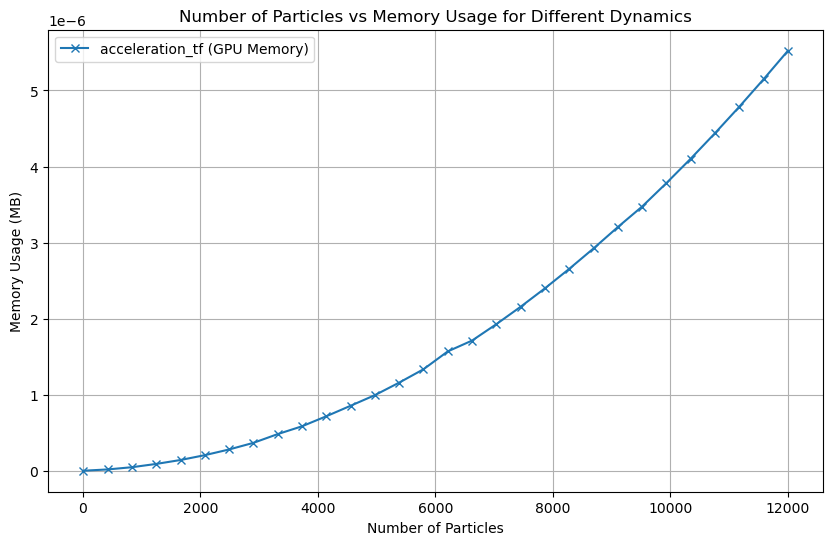

In [13]:
# Memory Usage Plot
plt.figure(figsize=(10, 6))

# Plotting non-TensorFlow memory results
for facc, label in zip(facc_list,
                       ['acceleration_direct',
                        'acceleration_direct_vectorized',
                        'acceleration_pyfalcon'
                        ]):
    memory = [output_results[n]['cpu_memory_usages'][facc_list.index(facc)] / 1e6 for n in N]  #  bytes to MB
    plt.plot(N, memory, marker='x', label=f'{label} (Memory)')

# Plotting TensorFlow memory results
for facc, label in zip(facc_list_tf, ['acceleration_tf']):
    memory = [output_results_tf[n]['gpu_memory_usages'][0] / 1e6 for n in N]  # Convert bytes to MB
    plt.plot(N, memory, marker='x', label=f'{label} (GPU Memory)')

plt.plot(N, memory_parallel_direct, marker='x', label='Parallel direct (Memory)')
plt.plot(N, memory_parallel_vec, marker='x', label='Parallel direct Vect(Memory)')
plt.xlabel('Number of Particles')
plt.ylabel('Memory Usage (MB)')
plt.title('Number of Particles vs Memory Usage for Different Dynamics')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def run_simulation_for_particles_and_cores(N_particles_list, total_evo_time, num_cores_list):
    results_parallel_vec = {}
    results_parallel_direct = {}
    
    for n_particles in N_particles_list:
        print(f"nparticles: {n_particles}")
        particles = fic.ic_random_uniform(
            n_particles,
            min_pos=min_pos,
            max_pos=max_pos,
            min_vel=min_vel,
            max_vel=max_vel,
            min_mass=min_mass,
            max_mass=max_mass
        )
        
        global pos, vel, mass
        
        pos = particles.pos
        vel = particles.vel
        mass = particles.mass
        N_particles = len(particles)
        tstep = 0.01

        for n_cores in num_cores_list:
            start = time.time()
            result_parallel_vec, _ = parallel_vectorized_evo(N_particles, total_evo_time=tstep, N_CORES=n_cores)
            time_vec = time.time() - start
            
            if n_cores not in results_parallel_vec:
                results_parallel_vec[n_cores] = []
                
            results_parallel_vec[n_cores].append({
                'n_particles': n_particles,
                'time': time_vec
            })

            start = time.time()
            result_parallel_direct, _ = parallel_direct_evo(N_particles, total_evo_time=tstep, N_CORES=n_cores)
            time_direct = time.time() - start
            
            if n_cores not in results_parallel_direct:
                results_parallel_direct[n_cores] = []
                
            results_parallel_direct[n_cores].append({
                'n_particles': n_particles,
                'time': time_direct
            })

    return results_parallel_vec, results_parallel_direct

In [12]:
num_cores_list = [2, 4, 8,12,16]
total_evo_time = 0.01

results_parallel_vec, results_parallel_direct = run_simulation_for_particles_and_cores(N_particles_list=N, total_evo_time=total_evo_time, num_cores_list=num_cores_list)

nparticles: 10


/home/draco/anaconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


nparticles: 1008
nparticles: 2007
nparticles: 3006
nparticles: 4005
nparticles: 5004
nparticles: 6003
nparticles: 7002
nparticles: 8001
nparticles: 9000


NameError: name 'result_parallel_direct' is not defined

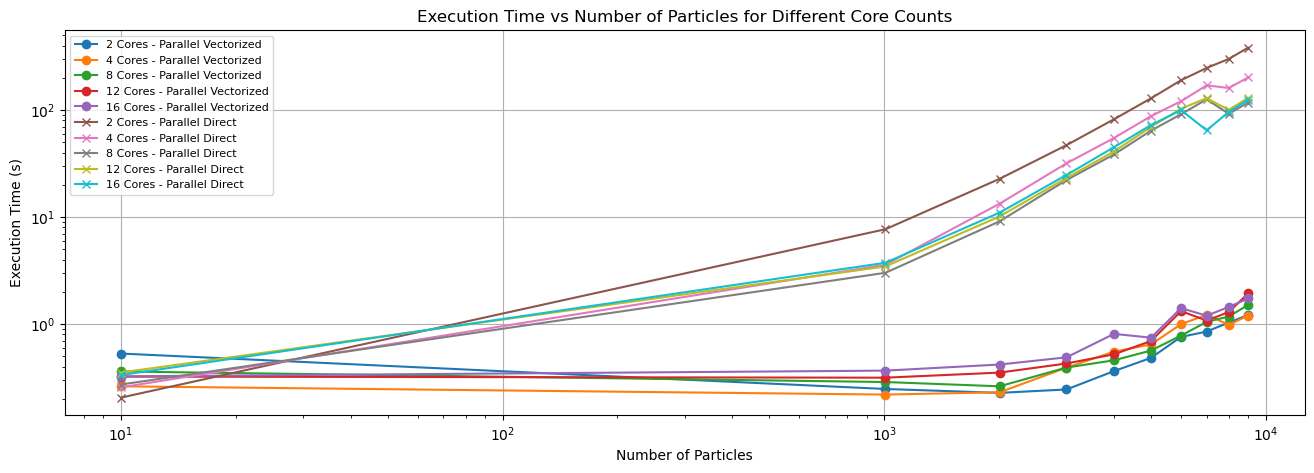

In [23]:
plt.figure(figsize=(16, 5))

# Plot results_parallel_vec
for n_cores, data_list in results_parallel_vec.items():
    n_particles = [entry['n_particles'] for entry in data_list]
    times = [entry['time'] for entry in data_list]
    plt.plot(n_particles, times, label=f'{n_cores} Cores - Parallel Vectorized',marker='o')

# Plot results_parallel_direct
for n_cores, data_list in results_parallel_direct.items():
    n_particles = [entry['n_particles'] for entry in data_list]
    times = [entry['time'] for entry in data_list]
    plt.plot(n_particles, times, label=f'{n_cores} Cores - Parallel Direct',marker='x')

plt.xlabel('Number of Particles')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Number of Particles for Different Core Counts')
plt.loglog()
plt.legend(fontsize='8')
plt.grid(True)
plt.show()

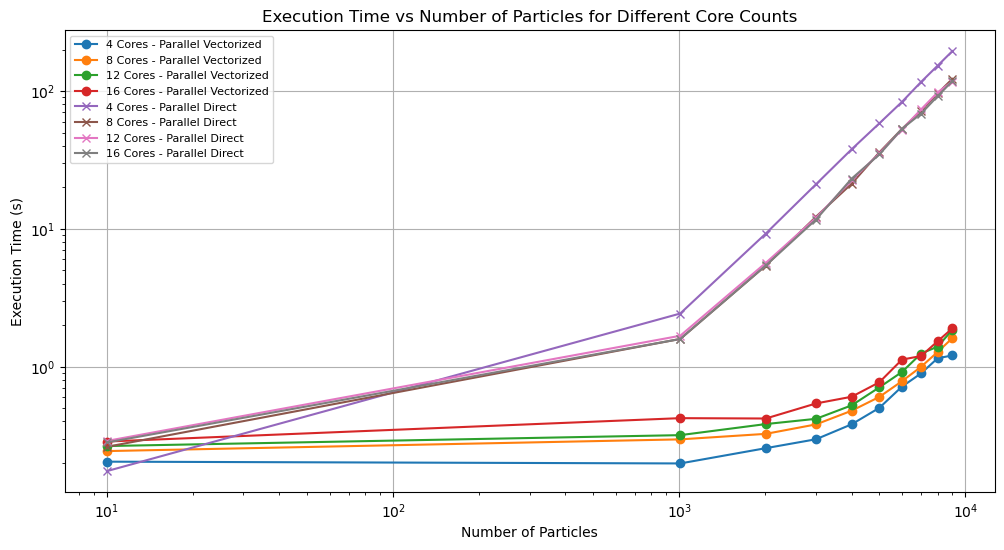

In [63]:
plt.figure(figsize=(12, 6))

# Cores to include
cores_to_include = [4, 8, 12, 16]

# Plot results_parallel_vec
for n_cores, data_list in results_parallel_vec.items():
    if n_cores in cores_to_include:
        n_particles = [entry['n_particles'] for entry in data_list]
        times = [entry['time'] for entry in data_list]
        plt.plot(n_particles, times, label=f'{n_cores} Cores - Parallel Vectorized', marker='o')

# Plot results_parallel_direct
for n_cores, data_list in results_parallel_direct.items():
    if n_cores in cores_to_include:
        n_particles = [entry['n_particles'] for entry in data_list]
        times = [entry['time'] for entry in data_list]
        plt.plot(n_particles, times, label=f'{n_cores} Cores - Parallel Direct', marker='x')

plt.xlabel('Number of Particles')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Number of Particles for Different Core Counts')
plt.loglog()
plt.legend(fontsize='8')
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (80,) and (10,)

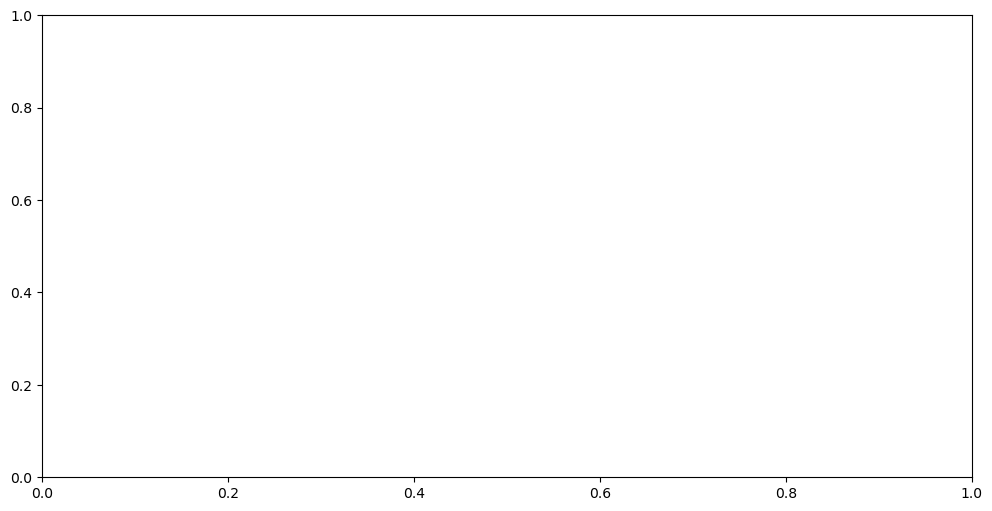

In [40]:
# # Save the results to JSON files
# with open('results_parallel_vec.json', 'w') as f:
#     json.dump(results_parallel_vec, f)

# with open('results_parallel_direct.json', 'w') as f:
#     json.dump(results_parallel_direct, f)

# Plot the results
plt.figure(figsize=(12, 6))

# Extract times for plotting
times_parallel_vec = {n_cores: [entry['time'] for entry in results] for n_cores, results in results_parallel_vec.items()}
times_parallel_direct = {n_cores: [entry['time'] for entry in results] for n_cores, results in results_parallel_direct.items()}

for n_cores, times in times_parallel_vec.items():
    plt.plot([n for n in N for _ in range(len(num_cores_list))], times, label=f'Vectorized - {n_cores} cores')

for n_cores, times in times_parallel_direct.items():
    plt.plot([n for n in N for _ in range(len(num_cores_list))], times, label=f'Direct - {n_cores} cores')

plt.xlabel('Number of Particles')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Number of Particles for Different Core Counts')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# # Define the file path
# file_path = 'compilation_times.txt'

# # Open the file in write mode
# with open(file_path, 'w') as file:
#     # Write the header
#     file.write("Particles,t_TF_cpu,t_parallel_vec,t_parallel_direct\n")
    
#     # Iterate over the dictionary and write data to the file
#     for idx, (particles, result) in enumerate(output_results_tf.items()):
#         compile_time = result['compile_times'][0]  # Assuming there's only one compile time per entry
#         t_parallel_vec = times_parallel_vec[idx] if idx < len(times_parallel_vec) else 0
#         t_parallel_direct = times_parallel_direct[idx] if idx < len(times_parallel_direct) else 0
#         file.write(f"{particles},{compile_time},{t_parallel_vec},{t_parallel_direct}\n")

# print("Data has been saved to", file_path)

Data has been saved to tf_cpu_compilation_times.txt


In [ ]:
# # Define the file path
# file_path = 'compilation_times.txt'

# # New column headers for the additional compile times
# column_headers = ["t_tf_gpu"]#"tf_parallel_direct", "t_vect", "t_pyfalcon"]

# # Read the existing data
# with open(file_path, 'r') as file:
#     lines = file.readlines()

# # Extract the header and the rest of the data
# header = lines[0].strip().split(',')
# data_lines = lines[1:]

# # Add new headers for the additional columns
# header.extend(column_headers)

# # Prepare the new data
# new_data = {}
# for particles, result in output_results_tf.items():#output_results.items():
#     new_data[particles] = result['compile_times']

# # Open the file in write mode to update it
# with open(file_path, 'w') as file:
#     # Write the updated header
#     file.write(",".join(header) + "\n")

#     # Update each line with the new compile times
#     for line in data_lines:
#         parts = line.strip().split(',')
#         particles = int(parts[0])
#         if particles in new_data:
#             compile_times = new_data[particles]
#             parts.extend(str(time) for time in compile_times)
#         file.write(",".join(parts) + "\n")

# print("Compilation times have been updated in", file_path)


In [10]:
# def measure_compile_time(particles, facc_list):
#     compile_times = []
#     for facc in facc_list:
#         t1 = time.perf_counter()
#         acceleration = facc(particles, softening=1e-10)
#         t2 = time.perf_counter()
#         dt = t2 - t1
#         print(f"Time taken for acceleration using {facc.__name__}: {dt} seconds \n")
#         compile_times.append(dt)
#     return compile_times

# def test_time_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
#     results = {}
#     for n_particles in tqdm(N, desc=" N"):
#         particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
#         compile_times = measure_compile_time(particles, facc_list)
#         results[n_particles] = {'particles': particles, 'compile_times': compile_times}
#     return results

# def test_time_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
#     results = {}
#     for n_particles in tqdm(N, desc=" N_tf"):
#         particles = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
#         compile_times = measure_compile_time(particles, facc_list)
#         results[n_particles] = {'particles': particles, 'compile_times': compile_times}
#     return results

In [71]:
results_dict = {
    "results_parallel_vec": {2: [{'n_particles': 10, 'time': 0.17107892036437988},
  {'n_particles': 1008, 'time': 0.1879901885986328},
  {'n_particles': 2007, 'time': 0.19587230682373047},
  {'n_particles': 3006, 'time': 0.3469202518463135},
  {'n_particles': 4005, 'time': 0.388916015625},
  {'n_particles': 5004, 'time': 0.5119156837463379},
  {'n_particles': 6003, 'time': 0.6583614349365234},
  {'n_particles': 7002, 'time': 0.9048173427581787},
  {'n_particles': 8001, 'time': 1.0200550556182861},
  {'n_particles': 9000, 'time': 1.5318787097930908}],
 4: [{'n_particles': 10, 'time': 0.20380139350891113},
  {'n_particles': 1008, 'time': 0.1978447437286377},
  {'n_particles': 2007, 'time': 0.25542306900024414},
  {'n_particles': 3006, 'time': 0.2964468002319336},
  {'n_particles': 4005, 'time': 0.3808012008666992},
  {'n_particles': 5004, 'time': 0.5013072490692139},
  {'n_particles': 6003, 'time': 0.7151007652282715},
  {'n_particles': 7002, 'time': 0.8925294876098633},
  {'n_particles': 8001, 'time': 1.1499817371368408},
  {'n_particles': 9000, 'time': 1.202967643737793}],
 6: [{'n_particles': 10, 'time': 0.26175355911254883},
  {'n_particles': 1008, 'time': 0.2309269905090332},
  {'n_particles': 2007, 'time': 0.2945544719696045},
  {'n_particles': 3006, 'time': 0.3206024169921875},
  {'n_particles': 4005, 'time': 0.4722621440887451},
  {'n_particles': 5004, 'time': 0.5506589412689209},
  {'n_particles': 6003, 'time': 0.6598749160766602},
  {'n_particles': 7002, 'time': 0.8619859218597412},
  {'n_particles': 8001, 'time': 1.1203484535217285},
  {'n_particles': 9000, 'time': 1.461130142211914}],
 8: [{'n_particles': 10, 'time': 0.24324369430541992},
  {'n_particles': 1008, 'time': 0.2958822250366211},
  {'n_particles': 2007, 'time': 0.3244500160217285},
  {'n_particles': 3006, 'time': 0.3800649642944336},
  {'n_particles': 4005, 'time': 0.47773098945617676},
  {'n_particles': 5004, 'time': 0.6019752025604248},
  {'n_particles': 6003, 'time': 0.7828550338745117},
  {'n_particles': 7002, 'time': 0.9962253570556641},
  {'n_particles': 8001, 'time': 1.2767665386199951},
  {'n_particles': 9000, 'time': 1.607231855392456}],
 10: [{'n_particles': 10, 'time': 0.28274011611938477},
  {'n_particles': 1008, 'time': 0.32257556915283203},
  {'n_particles': 2007, 'time': 0.3512907028198242},
  {'n_particles': 3006, 'time': 0.40195369720458984},
  {'n_particles': 4005, 'time': 0.545034646987915},
  {'n_particles': 5004, 'time': 0.6872637271881104},
  {'n_particles': 6003, 'time': 0.8481979370117188},
  {'n_particles': 7002, 'time': 1.0773696899414062},
  {'n_particles': 8001, 'time': 1.3786709308624268},
  {'n_particles': 9000, 'time': 1.7421517372131348}],
 12: [{'n_particles': 10, 'time': 0.2646317481994629},
  {'n_particles': 1008, 'time': 0.31755828857421875},
  {'n_particles': 2007, 'time': 0.3821723461151123},
  {'n_particles': 3006, 'time': 0.41725587844848633},
  {'n_particles': 4005, 'time': 0.5226635932922363},
  {'n_particles': 5004, 'time': 0.706169605255127},
  {'n_particles': 6003, 'time': 0.9134013652801514},
  {'n_particles': 7002, 'time': 1.2425415515899658},
  {'n_particles': 8001, 'time': 1.3961973190307617},
  {'n_particles': 9000, 'time': 1.8456125259399414}],
 14: [{'n_particles': 10, 'time': 0.312816858291626},
  {'n_particles': 1008, 'time': 0.3667759895324707},
  {'n_particles': 2007, 'time': 0.40898990631103516},
  {'n_particles': 3006, 'time': 0.521125316619873},
  {'n_particles': 4005, 'time': 0.5635402202606201},
  {'n_particles': 5004, 'time': 0.7407999038696289},
  {'n_particles': 6003, 'time': 0.9015426635742188},
  {'n_particles': 7002, 'time': 1.1881933212280273},
  {'n_particles': 8001, 'time': 1.6724207401275635},
  {'n_particles': 9000, 'time': 1.8147904872894287}],
 16: [{'n_particles': 10, 'time': 0.28539538383483887},
  {'n_particles': 1008, 'time': 0.42188072204589844},
  {'n_particles': 2007, 'time': 0.4194159507751465},
  {'n_particles': 3006, 'time': 0.539473295211792},
  {'n_particles': 4005, 'time': 0.6035397052764893},
  {'n_particles': 5004, 'time': 0.7689650058746338},
  {'n_particles': 6003, 'time': 1.1232271194458008},
  {'n_particles': 7002, 'time': 1.1923320293426514},
  {'n_particles': 8001, 'time': 1.527867078781128},
  {'n_particles': 9000, 'time': 1.891456127166748}]},
"results_parallel_direct": {2: [{'n_particles': 10, 'time': 0.12438201904296875},
  {'n_particles': 1008, 'time': 4.653375864028931},
  {'n_particles': 2007, 'time': 18.102187395095825},
  {'n_particles': 3006, 'time': 40.55958271026611},
  {'n_particles': 4005, 'time': 72.90445351600647},
  {'n_particles': 5004, 'time': 112.65786838531494},
  {'n_particles': 6003, 'time': 158.79359889030457},
  {'n_particles': 7002, 'time': 220.5532031059265},
  {'n_particles': 8001, 'time': 285.65584325790405},
  {'n_particles': 9000, 'time': 368.1815643310547}],
 4: [{'n_particles': 10, 'time': 0.1739957332611084},
  {'n_particles': 1008, 'time': 2.426447868347168},
  {'n_particles': 2007, 'time': 9.243149995803833},
  {'n_particles': 3006, 'time': 21.078994750976562},
  {'n_particles': 4005, 'time': 37.86115527153015},
  {'n_particles': 5004, 'time': 58.38612771034241},
  {'n_particles': 6003, 'time': 83.57673358917236},
  {'n_particles': 7002, 'time': 116.72089099884033},
  {'n_particles': 8001, 'time': 153.24730896949768},
  {'n_particles': 9000, 'time': 195.25667786598206}],
 6: [{'n_particles': 10, 'time': 0.2081434726715088},
  {'n_particles': 1008, 'time': 1.796438217163086},
  {'n_particles': 2007, 'time': 6.50060510635376},
  {'n_particles': 3006, 'time': 14.818899154663086},
  {'n_particles': 4005, 'time': 26.44816517829895},
  {'n_particles': 5004, 'time': 40.82418417930603},
  {'n_particles': 6003, 'time': 64.55882287025452},
  {'n_particles': 7002, 'time': 85.34423422813416},
  {'n_particles': 8001, 'time': 113.43600177764893},
  {'n_particles': 9000, 'time': 144.16330933570862}],
 8: [{'n_particles': 10, 'time': 0.2612593173980713},
  {'n_particles': 1008, 'time': 1.5858478546142578},
  {'n_particles': 2007, 'time': 5.413399696350098},
  {'n_particles': 3006, 'time': 12.249836921691895},
  {'n_particles': 4005, 'time': 21.28058624267578},
  {'n_particles': 5004, 'time': 35.923619747161865},
  {'n_particles': 6003, 'time': 53.195626735687256},
  {'n_particles': 7002, 'time': 72.0232663154602},
  {'n_particles': 8001, 'time': 96.2509708404541},
  {'n_particles': 9000, 'time': 122.77912664413452}],
 10: [{'n_particles': 10, 'time': 0.27621936798095703},
  {'n_particles': 1008, 'time': 1.741199254989624},
  {'n_particles': 2007, 'time': 6.167306184768677},
  {'n_particles': 3006, 'time': 13.564091444015503},
  {'n_particles': 4005, 'time': 23.615150451660156},
  {'n_particles': 5004, 'time': 39.73110795021057},
  {'n_particles': 6003, 'time': 58.54068040847778},
  {'n_particles': 7002, 'time': 79.07119750976562},
  {'n_particles': 8001, 'time': 102.85045337677002},
  {'n_particles': 9000, 'time': 131.47759628295898}],
 12: [{'n_particles': 10, 'time': 0.2882266044616699},
  {'n_particles': 1008, 'time': 1.6731030941009521},
  {'n_particles': 2007, 'time': 5.661540508270264},
  {'n_particles': 3006, 'time': 12.010993719100952},
  {'n_particles': 4005, 'time': 22.558088779449463},
  {'n_particles': 5004, 'time': 35.30449938774109},
  {'n_particles': 6003, 'time': 52.64736986160278},
  {'n_particles': 7002, 'time': 73.71336388587952},
  {'n_particles': 8001, 'time': 98.00472021102905},
  {'n_particles': 9000, 'time': 117.41472792625427}],
 14: [{'n_particles': 10, 'time': 0.32440996170043945},
  {'n_particles': 1008, 'time': 1.6291301250457764},
  {'n_particles': 2007, 'time': 5.502983808517456},
  {'n_particles': 3006, 'time': 12.192058324813843},
  {'n_particles': 4005, 'time': 23.798699855804443},
  {'n_particles': 5004, 'time': 35.52970862388611},
  {'n_particles': 6003, 'time': 55.95823884010315},
  {'n_particles': 7002, 'time': 71.23829746246338},
  {'n_particles': 8001, 'time': 88.3861870765686},
  {'n_particles': 9000, 'time': 118.17167448997498}],
 16: [{'n_particles': 10, 'time': 0.2810041904449463},
  {'n_particles': 1008, 'time': 1.5851905345916748},
  {'n_particles': 2007, 'time': 5.421546459197998},
  {'n_particles': 3006, 'time': 11.685121059417725},
  {'n_particles': 4005, 'time': 23.17183566093445},
  {'n_particles': 5004, 'time': 34.686373472213745},
  {'n_particles': 6003, 'time': 53.24421238899231},
  {'n_particles': 7002, 'time': 68.72530198097229},
  {'n_particles': 8001, 'time': 92.03721904754639},
  {'n_particles': 9000, 'time': 118.30299925804138}]}
}

In [72]:
results_dict.keys()

dict_keys(['results_parallel_vec', 'results_parallel_direct'])

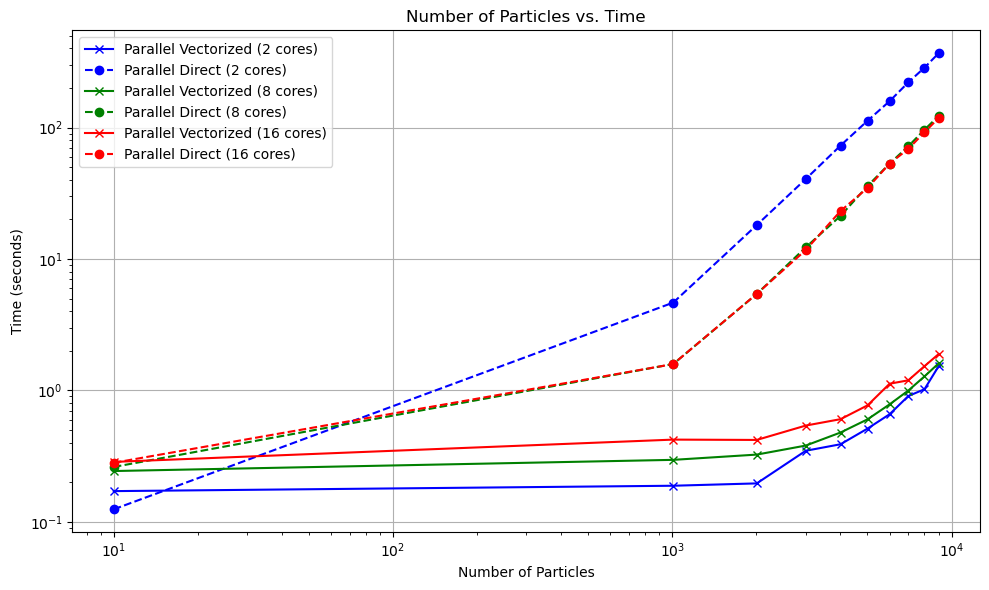

In [80]:
import matplotlib.pyplot as plt

# Extract data for plotting
def extract_data(results, num_particles):
    data = results[num_particles]
    n_particles_list = [entry['n_particles'] for entry in data]
    time_list = [entry['time'] for entry in data]
    return n_particles_list, time_list

# Selected number of particles and corresponding colors
selected_cores = [2, 8,16]
colors = ['blue', 'green', 'red', 'orange', 'purple']

plt.figure(figsize=(10, 6))

for idx, cores in enumerate(selected_cores):
    n_particles_vec, time_vec = extract_data(results_parallel_vec, cores)
    n_particles_direct, time_direct = extract_data(results_parallel_direct, cores)
    plt.plot(n_particles_vec, time_vec, marker='x', color=colors[idx], label=f'Parallel Vectorized ({cores} cores)')
    plt.plot(n_particles_direct, time_direct, marker='o', linestyle='--', color=colors[idx], label=f'Parallel Direct ({cores} cores)')

plt.title('Number of Particles vs. Time')
plt.xlabel('Number of Particles')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.legend()
plt.loglog()
plt.tight_layout()
plt.show()
